# Problem 5

Download CIFAR10 

In [ ]:
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

What is TTA stability? 
What does it mean for a model to be optimized for TTA?

How can we compute the coefficient of variation of TTA

As mentioned on campuswire, we use RTX8000 instead of TPU pod

The Resnet50 implementation that we will use in this assignment is from this [github repo](https://github.com/akamaster/pytorch_resnet_cifar10)

In [11]:
from resnet import ResNet, BasicBlock, test

def resnet50():
    return ResNet(BasicBlock, [8, 8, 8])

net = resnet50()
test(net)

Total number of params 755802
Total layers 50


In [12]:
from re import I
import time
import copy
import torch
import logging
import os
from os import path
from math import floor
import pandas as pd
import numpy as np

def setup_logging(log_file='log.txt', resume=False):
    """
    Setup logging configuration
    """
    file_mode = 'a' if os.path.isfile(log_file) and resume else 'w'

    root_logger = logging.getLogger()
    logging.basicConfig(level=logging.DEBUG,
                        format="%(asctime)s - %(levelname)s - %(message)s",
                        datefmt="%Y-%m-%d %H:%M:%S")
    # Remove all existing handlers (can't use the `force` option with
    # python < 3.8)
    for hdlr in root_logger.handlers[:]:
        root_logger.removeHandler(hdlr)
    # Add the handlers we want to use
    fileout = logging.FileHandler(log_file, mode=file_mode)
    fileout.setLevel(logging.DEBUG)
    fileout.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
    logging.getLogger().addHandler(fileout)
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    console.setFormatter(logging.Formatter('%(message)s'))
    logging.getLogger().addHandler(console)


def train_model(model, dataloaders, criterion, optimizer, num_epochs=200, scheduler=None, save_path="./", show_iteration_info=False, model_name=None, colab=False, limit_num_epochs=20):
    """
    Function to train a deep learning model. 
        model: a pytorch model 
        dataloaders: a dictionary with 'train' and 'val' keys with their respective dataloaders
        criterion: the loss function 
        optimizer: the optimizer to be used
        num_epochs: number of epochs to train
        scheduler: if it is specified, the scheduler will be used
        save_path: the directory where we can save the model and the log output.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    path_created = False
    # Check whether the specified path exists or not
    if not os.path.exists(save_path):
        # Create a new directory because it does not exist 
        os.makedirs(save_path)
        path_created = True

    setup_logging(os.path.join(save_path, 'log.txt'))

    if path_created:
        logging.info(f"'{save_path}' Directory was created!")

    logging.info(f"Starting training on: device={device}\n")
    # Print information about the hardware used in google colab
    # if colab:
    #     gpu_info = !nvidia-smi
    #     gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
    #     gpu_info = '\n'.join(gpu_info)
    #     if gpu_info.find('failed') >= 0:
    #         logging.info('Not connected to a GPU')
    #     else:
    #         logging.info(gpu_info)
    #     logging.info(gpu_name)

    if model_name is not None:
        logging.info(f"Training {model_name}")

    logging.info("Model information: ")
    total_params = 0
    for x in filter(lambda p: p.requires_grad, model.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    logging.info(f"\tTotal number of params: {round(total_params/1e6, 2)}M")
    logging.info(f"\tTotal layers {len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, model.parameters())))}")

    model_name = '' if model_name is None else model_name
    logging.info(f"Optimizer: {optimizer}")
    if scheduler is not None:
        logging.info(f"Scheduler: {scheduler.state_dict()}")

    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    df = pd.DataFrame(columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
    model.to(device)
    best_acc_updated_on = 0
    for epoch in range(num_epochs):
        logging.info('Epoch {}/{}'.format(epoch, num_epochs - 1))
        logging.info('-' * 10)
        info = {'train': None, 'val': None}
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_number_of_samples = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_number_of_samples += labels.shape[0]
                report = str('{phase} - Epoch: [{0}][{1}/{2}]\t'
                            f'Loss {loss.item()} (avg: {running_loss/running_number_of_samples})\t'
                            f'Acc {torch.sum(preds == labels.data)/labels.shape[0]}, (avg: {running_corrects/running_number_of_samples})\t'
                            .format(
                                epoch, i, len(dataloaders[phase]),
                                phase=phase))  
                if show_iteration_info: 
                    logging.info(report)
    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logging.info('{} Loss: {:.4f} Acc: {:.4f} \t model: {}'.format(phase, epoch_loss, epoch_acc, model_name))
            info[phase] = (epoch_loss, epoch_acc.item())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc_updated_on = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                logging.info(f"best acc: {best_acc:.4f}")
            if phase == 'val':
                val_acc_history.append(epoch_acc)


        # Save info on dataframe 
        train_loss = info['train'][0]
        train_acc = info['train'][1]
        test_loss = info['val'][0]
        test_acc = info['val'][1]

        df.loc[len(df.index)] = [epoch, train_loss, train_acc, test_loss, test_acc]

        # if  epoch - best_acc_updated_on > limit_num_epochs:
        #     logging.info(f"Terminating training because accuracy has not improved in {limit_num_epochs} epochs")
        #     break

        # make a step on the scheduler every epoch
        if scheduler is not None:
            scheduler.step()
            logging.info(f"Scheduler: {scheduler.state_dict()}")

        logging.info("")

    time_elapsed = time.time() - since
    logging.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    logging.info('Best val Acc: {:4f}'.format(best_acc))
    df.to_csv(os.path.join(save_path, 'training_info.csv'))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


def get_conv_info(layer, input_shape, spaces=''):
    """Compute information from convolution layer"""
    # Get input information from the layer
    batch_size = input_shape[0]
    I_c = input_shape[1]
    I_w = input_shape[2]
    I_h = input_shape[3]
    k = layer.weight.shape[-1]
    logging.info(f'{spaces}kernel:{k=}x{k=}')
    s = layer.stride[0]
    logging.info(f'{spaces}stride:{s=}')
    p = layer.padding[0]
    logging.info(f'{spaces}padding:{p=}')
    # Calculate output information
    O_c = layer.weight.shape[0] 
    O_w = floor((I_w - k + 2*p)/s) + 1
    O_h = floor((I_h - k + 2*p)/s) + 1
    logging.info(f'{spaces}Input Size: {I_w=} {I_h=} {I_c=}')
    logging.info(f"{spaces}Output size: {O_w=} {O_h=} {O_c=}")
    logging.info(f"{spaces}Weights per filter: {k=}x{k=}x{I_c=} = {k*k*I_c}")
    logging.info(f"{spaces}Parameters: {k=}x{k=}x{I_c=}x{O_c=} + {O_c=} biases = {k*k*I_c*O_c + O_c:,}")
    logging.info(f"{spaces}Number of Multiply-Adds: ({I_h=}x{I_w=}x{I_c=})x({k=}x{k=}x{O_c=}) = {I_h*I_w*I_c*k*k*O_c:,}")

    # --------------------------------------------------------------------------------------------------
    # This part is important for calculating flops from Lu. et al "Modeling the resource requirements ..."
    # --------------------------------------------------------------------------------------------------
    matrix = (O_h*O_w)*(k*k*I_c)*(k*k*I_c)*(O_c)
    logging.info(f"{spaces}Matrix Multiplication size: [({O_h=}x{O_w=})x({k=}x{k=}x{I_c=})][({k=}x{k=}x{I_c=})x({O_c=})] = {(O_h*O_w)*(k*k*I_c):,}x{(k*k*I_c)*(O_c):,} = {matrix:,}")
    return k*k*I_c*O_c

def get_layer_info(index, layer, input_shape, output, biases=False, spaces=''):
    """ logging.infos the information of a certain layer
        Returns the activation number and the number of parameters """
    activations = output.numel()
    parameters = 0
    if isinstance(layer, torch.nn.ReLU) :
        return 0, 0 
    logging.info(f"{spaces}{index}) {layer.__class__.__name__}")
    if isinstance(layer, torch.nn.Flatten) or isinstance(layer, torch.nn.Dropout):
        return 0, 0 
    if isinstance(layer, torch.nn.Sequential):
        for i, layer_layer in enumerate(layer):
            get_layer_info(f"{index}_{i}", layer_layer, input_shape, output, biases, spaces=spaces*2 if len(spaces) > 0 else "    ")
    if isinstance(layer, torch.nn.Conv2d):
        get_conv_info(layer=layer, input_shape=input_shape, spaces=spaces*2 if len(spaces) > 0 else "    ")
    logging.info(f'{spaces*2}* number of activations: output_shape={output.shape}, -> {output.numel():,}')
    # We only count the linear layer and conv layers
    if isinstance(layer, torch.nn.Linear) or isinstance(layer, torch.nn.Conv2d):
        params = list(layer.parameters())
        logging.info(f"{spaces*2}Weights:", params[0].shape)
        logging.info(f"{spaces*2}Biases:", params[1].shape)
        if biases:
            parameters = parameters + params[1].shape[0]
        parameters = parameters + layer.weight.numel()
        logging.info(f'{spaces*2}- parameters: weights={layer.weight.shape}, -> {parameters:,}')
    return activations, parameters


def get_parameters(model, input_size=(3, 200, 200), biases=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X = torch.randn(input_size).unsqueeze(0).to(device)
    total_activations = []
    total_parameters = []
    logging.info("Input:", 
            f'\n    number of activations: {X.shape}, {X.numel():,}')
    total_activations.append(X.numel())
    for i, layer in enumerate(model):
            input_shape = X.shape
            X=layer(X)
            activations, parameters = get_layer_info(i, layer, input_shape=input_shape, output=X, biases=biases)
            total_parameters.append(parameters)
            total_activations.append(activations)
    logging.info("\n")
    parameters = sum(total_parameters)
    activations = sum(total_activations)
    logging.info(f"Total number of Parameters: {parameters:,}")
    logging.info(f"Total number of Activations: {activations:,}")
    return parameters, activations

In [17]:
from torch import nn, optim
model = resnet50()
params_to_update = model.parameters()
lr = 0.001
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=lr, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 180], gamma=0.1)
train_model(model, dataloaders, criterion, optimizer, num_epochs=350, scheduler=scheduler, save_path=args.save)

NameError: name 'dataloaders' is not defined

In [7]:
import pandas as pd

df = pd.read_csv("./GPU_info.csv")

<AxesSubplot:>

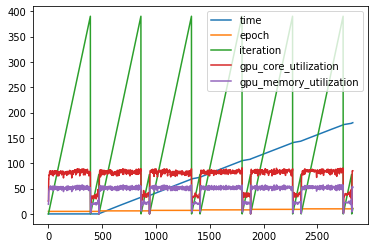

In [8]:
df.plot()